前準備

In [1]:
#numpy, matplotlib, pandasのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import unicodedata
import seaborn as sns
import itertools

#日付データの変更のためインポート
import datetime as dt

# 欠損値補完(MICE)のためにインポート
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# RFEのためにインポート
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

#lightGBMのインポート
import lightgbm as lgb

#訓練データとテストデータ分割のためにインポート
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#標準化のためインポート
from sklearn.preprocessing import StandardScaler

#エンコーディングのためインポート
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#精度検証のためインポート
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

#ハイパーパラメータチューニングのためにインポート
from sklearn.model_selection import GridSearchCV

#特徴量選択のためにインポート
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

#ロジスティック回帰のためにインポート
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

#SVMのためにインポート
from sklearn import svm

#決定木のためにインポート
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#ランダムフォレストのためにインポート
from sklearn.ensemble import RandomForestClassifier

#アダブーストのためにインポート
from sklearn.ensemble import AdaBoostClassifier

#CatBoostのためにインポート
from catboost import CatBoostClassifier
from catboost import Pool

# SMOTEのためにインポート
# from imblearn.over_sampling import SMOTE

C:\Users\yutak\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# notebookの設定

# データフレームの最大表示行数、列数を広げる
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# 図のサイズ
plt.rcParams["figure.figsize"]=(8,4)

# matplotlibのフォント
font = 'Yu Mincho'

In [4]:
#学習データ、テストデータの読み込み
train0 = pd.read_csv('dataset/train.csv')
test0 = pd.read_csv('dataset/test.csv')

In [5]:
train0

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,3484,40歳,Self Enquiry,2,1560秒,Salaried,Male,2.0,3.0,Basic,3.0,3,0,1,Executive,258900.0,離婚済み 乗用車所持 子供なし,1
3485,3485,40代,Self Enquiry,1,9分,Large Business,Male,3.0,3.0,Basic,5.0,5,0,3,Executive,260415.0,結婚済み、車所持、子供2人,0
3486,3486,31歳,Self Enquiry,1,840秒,Small Business,FEMALE,3.0,2.0,Standard,3.0,5,0,4,Senior Manager,317340.0,独身／車所持／こども1人,0
3487,3487,56歳,Company Invited,2,900秒,Salaried,Male,3.0,6.0,King,3.0,7,1,4,VP,527910.0,結婚済み、自動車未所有、子供2人,1


In [6]:
test0

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info
0,3489,４８歳,Self Enquiry,2,13分,Small Business,Male,1.0,4.0,Super De|uxe,3.0,7,0,3,AVP,496950.0,結婚済み 車所持 子供なし
1,3490,30代,Self Enquiry,2,12分,Small Business,Ｆｅｍａｌｅ,1.0,4.0,Standard,3.0,4,1,3,Senior Manager,月収30.0万円,結婚済み、車未所持、子供なし
2,3491,25歳,Self Enquiry,1,540秒,Salaried,Female,1.0,4.0,Basic,3.0,1,0,3,Executive,月収26.0万円,離婚済み、自動車未所有、子供なし
3,3492,21歳,Company Invited,2,420秒,Salaried,Male,1.0,4.0,Basic,4.0,1,0,3,Senior Manager,259875.0,離婚済み、自動車所有、子供なし
4,3493,41歳,Company Invited,1,7分,Salaried,MALE,1.0,4.0,Basic,3.0,1,0,4,Executive,268830.0,独身/車所持／子供なし
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,6973,41歳,Company Invited,1,14分,Small Business,Female,1.0,3.0,Basic,3.0,2,0,4,Executive,261840.0,結婚済み/車なし／子供無し
3485,6974,44歳,Company Invited,1,35分,Salaried,Male,3.0,5.0,Deluxe,3.0,3,0,3,Manager,349770.0,結婚済み、自家用車あり、子供1人
3486,6975,24歳,Self Enquiry,2,21分,Small Business,male,2.0,3.0,basic,3.0,2,0,3,Executive,月収27.0万円,独身、車未所持、子供なし
3487,6976,25歳,Self Enquiry,1,9分,Small Business,MALE,2.0,3.0,Basic,3.0,2,0,3,Executive,272430.0,結婚済み、車未所持、こども1人


In [7]:
# 不要な変数の削除

# 変数名と列番号の対応を表示
col = pd.DataFrame(train0.columns.values).T

# dropの実行,事故率に関係ないデータは予測に利用できないのでdrop(後々他の変数をdropしたくなった時楽な様に列番号でdropする)
train1 = train0.drop(train0.columns[0],axis=1) 
test1 = test0.drop(test0.columns[0],axis=1)

In [8]:
test1.isnull().sum()

Age                        93
TypeofContact              12
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          24
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              49
customer_info               0
dtype: int64

In [186]:
train_x = train1.drop(['ProdTaken'], axis=1)
train_y = train1['ProdTaken']
test_x = test1

def preprocessing(train_x, test_x):
    # Age numeric
    def process_age(age):
        kanji_to_num = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0}
        def kanji_to_arabic(kanji):
            result = 0
            temp = 0
            for char in kanji:
                value = kanji_to_num.get(char, None)
                if value is not None:
                    if value < 10:
                        if temp == 0:
                            temp = value
                        else:
                            temp = temp * 10 + value
                    elif value >= 10:
                        if temp == 0:
                            temp = 1
                        result += temp * value
                        temp = 0
            return result + temp
        if age is None or str(age) == 'nan':
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # TypeofContact categorical(dummy)
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0
        
    # CityTier 順序尺度
    
    # DurationOfPitch numeric
    def convert_to_minutes(duration):
        # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
        if pd.isnull(duration):
            return None  # NaNの場合、Noneを返す
        duration = str(duration)  # 文字列に変換してエラーを防ぐ
        if '分' in duration:
            return float(duration.replace('分', ''))
        elif '秒' in duration:
            return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

    # Occupation categorical
    def Occupation_dealing(str):
        if str == 'Large Business':
            return 2
        elif str == 'Small Business':
            return 1
        elif str == 'Salaried':
            return 0
       
    # Gender categorical
    def Gender_dealing(gender):
        # 文字列を半角に変換し、大文字に統一
        gender = unicodedata.normalize('NFKC', gender).upper().strip()
        # 不要な空白を削除
        gender = ''.join(gender.split())

        if 'FEMALE' in gender:
            return 1
        elif 'MALE' in gender:
            return 0
        else:
            return None  # 性別が識別できない場合はNoneを返す
        
    # NumberOfPersonVisiting numeric
    
    # NumberOfFollowups numeric
    def NumberOfFollowups_dealing(input_int):
        if input_int >= 100:
            input_int = input_int / 100
        return input_int
    
    # ProductPitched categorical
    # Designation categorical
    def standardize_str(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = ''.join(input_str.split())
        input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
        # その他特殊文字を通常の英字に置換
        input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
        input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
        input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
        input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
        input_str = input_str.replace('aasic', 'basic')
        return input_str
    
    def ProductPitched_dealing(input_str):
        if input_str == 'basic':
            return 0
        elif input_str == 'standard':
            return 1
        elif input_str == 'deluxe':
            return 2
        elif input_str == 'superdeluxe':
            return 3
        elif input_str == 'king':
            return 4
        
#     def Designation_dealing(input_str):
        
    
    # PreferredPropertyStar 順序尺度
    
    # NumberOfTrips numeric
    def NumberOfTrips_dealing(str):
        if pd.isnull(str):
            return None 
        if '半年に' in str:
            return 2 * int(str.replace('半年に', '').replace('回', ''))
        elif '年に' in str:
            return int(str.replace('年に', '').replace('回', ''))
        elif '四半期に' in str:
            return 4 * int(str.replace('四半期に', '').replace('回', ''))
        else :
            return int(str)
        
    # Passport categorical(dummy)
    
    # PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
    
    # MonthlyIncome numeric
    def MonthlyIncome_dealing(input_str):
        if pd.isnull(input_str):
            return None 
        if '月収' in input_str:
            return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
        elif '万円' in input_str:
            return 10000 * float(input_str.replace('万円', ''))
        else:
            return float(input_str)
        
    # customer_info
    def customer_info_dealing(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
        input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
        input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
        return input_str
    
    # Married categorical
    
    # CarPossesion categorival(dummy)
    def CarPossesion_dealing(input_str):
        if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
            return 0
        elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
            return 1
        
    # Offspring numeric
    def Offspring_dealing(input_str):
        if '1' in input_str:
            return 1
        elif '2' in input_str:
            return 2
        elif '3' in input_str:
            return 3
        elif input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
            return None
        else:
            return 0
        
    def function_apply(input_df):
        df = input_df.copy()
        df['Age'] = df['Age'].apply(process_age)
        df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
        df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
        df['Occupation'] = df['Occupation'].apply(Occupation_dealing)
        df['Gender'] = df['Gender'].apply(Gender_dealing)
        df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
        df['ProductPitched'] = df['ProductPitched'].apply(standardize_str)
        df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
        df['Designation'] = df['Designation'].apply(standardize_str)
        df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)
        df['customer_info'] = df['customer_info'].apply(customer_info_dealing)
        df[['Married', 'CarPossesion', 'Offspring']] = df['customer_info'].str.split(',', n=2, expand=True)
        df = df.drop(['customer_info'],axis=1)
        df['CarPossesion'] = df['CarPossesion'].apply(CarPossesion_dealing)
        df['Offspring'] = df['Offspring'].apply(Offspring_dealing)
        return df
    
    def column_addition(train_x, test_x,dummy_col, std_col):
        categorical_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion']
        numeric_columns = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'Offspring']
        tr_x = train_x.copy()
        te_x = test_x.copy()
#         for cols in itertools.combinations(categorical_columns, 2):
#             tr_x[f'{cols[0]}_{cols[1]}'] = tr_x[cols[0]].astype(str) + '_' + tr_x[cols[1]].astype(str)
#             te_x[f'{cols[0]}_{cols[1]}'] = te_x[cols[0]].astype(str) + '_' + te_x[cols[1]].astype(str)
#             dummy_col.append(f'{cols[0]}_{cols[1]}')
        return tr_x, te_x, dummy_col
        
    def dummy_ex(feature, train_x, test_x, categorical_features):
        # OneHotEncoder の初期化時に sparse_output 引数を使用
        ohe = OneHotEncoder(sparse_output=False, categories='auto')
        new_array = pd.concat([train_x[[feature]], test_x[[feature]]], axis=0)
        ohe.fit(new_array)
        columns = [f'{feature}_{v}' for v in ohe.categories_[0]]
        dummy_vals_train = pd.DataFrame(ohe.transform(train_x[[feature]]), columns=columns)
        dummy_vals_test = pd.DataFrame(ohe.transform(test_x[[feature]]), columns=columns)
        tr = pd.concat([train_x.drop([feature], axis=1), dummy_vals_train.reset_index(drop=True)], axis=1)
        te = pd.concat([test_x.drop([feature], axis=1), dummy_vals_test.reset_index(drop=True)], axis=1)
        categorical_features = categorical_features + columns
        return tr, te, categorical_features
    
    def dealing_missing_values(input_df):
        df = input_df.copy()
        df['TypeofContact'] = df['TypeofContact'].fillna(df['TypeofContact'].mode().iloc[0])
#         df['Age'] = df['Age'].fillna(df['Age'].mean())
#         df['DurationOfPitch'] = df['DurationOfPitch'].fillna(df['DurationOfPitch'].mean())
#         df['NumberOfFollowups'] = df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].mean())
#         df['NumberOfTrips'] = df['NumberOfTrips'].fillna(df['NumberOfTrips'].mean())
#         df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean())
        columns_to_impute = ['Age', 'DurationOfPitch','NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'Offspring']
        df_imputed_subset = pd.DataFrame(IterativeImputer().fit_transform(df[columns_to_impute]), columns=columns_to_impute)
        df[columns_to_impute] = df_imputed_subset
        return df    
    
    def function_apply_both(train_x, test_x, dummy_col, std_col):
        def function_call(func, tr_x, te_x):
            return func(tr_x), func(te_x)
        
        tr_x = train_x.copy()
        te_x = test_x.copy()
        tr_x, te_x = function_call(function_apply, tr_x, te_x)
        tr_x, te_x = function_call(dealing_missing_values, tr_x, te_x)
        tr_x_cleaned = tr_x.copy()
        te_x_cleaned = te_x.copy()
        tr_x, te_x, dummy_col = column_addition(tr_x, te_x, dummy_col, std_col)
        categorical_features = ['TypeofContact', 'Gender', 'Passport', 'CarPossesion'] #すでにdummyのもの
        for feature in dummy_col:
            tr_x, te_x, categorical_features = dummy_ex(feature, tr_x, te_x, categorical_features)
        std_sc = StandardScaler()
        tr_x[std_col] = std_sc.fit_transform(tr_x[std_col])
        te_x[std_col] = std_sc.fit_transform(te_x[std_col])
        return tr_x, te_x, tr_x_cleaned, te_x_cleaned, categorical_features
    
    global dummy_col
    global std_col
    tr_x, te_x, tr_x_cleaned, te_x_cleaned, categorical_features = function_apply_both(train_x, test_x, dummy_col, std_col)
    
    print('Preprocessing finished')
    return tr_x, te_x, tr_x_cleaned, te_x_cleaned, categorical_features

dummy_col = ['CityTier', 'Occupation', 'ProductPitched', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'Designation', 'Married']
std_col = ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'Offspring']

train_x, test_x, tr_x_cleaned, te_x_cleaned, categorical_features = preprocessing(train_x, test_x)

Preprocessing finished


In [176]:
categorical_features

['TypeofContact',
 'Gender',
 'Passport',
 'CarPossesion',
 'CityTier_1',
 'CityTier_2',
 'CityTier_3',
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'ProductPitched_basic',
 'ProductPitched_deluxe',
 'ProductPitched_king',
 'ProductPitched_standard',
 'ProductPitched_superdeluxe',
 'PreferredPropertyStar_3.0',
 'PreferredPropertyStar_4.0',
 'PreferredPropertyStar_5.0',
 'PitchSatisfactionScore_1',
 'PitchSatisfactionScore_2',
 'PitchSatisfactionScore_3',
 'PitchSatisfactionScore_4',
 'PitchSatisfactionScore_5',
 'Designation_avp',
 'Designation_executive',
 'Designation_manager',
 'Designation_seniormanager',
 'Designation_vp',
 'Married_未婚',
 'Married_独身',
 'Married_結婚済み',
 'Married_離婚済み']

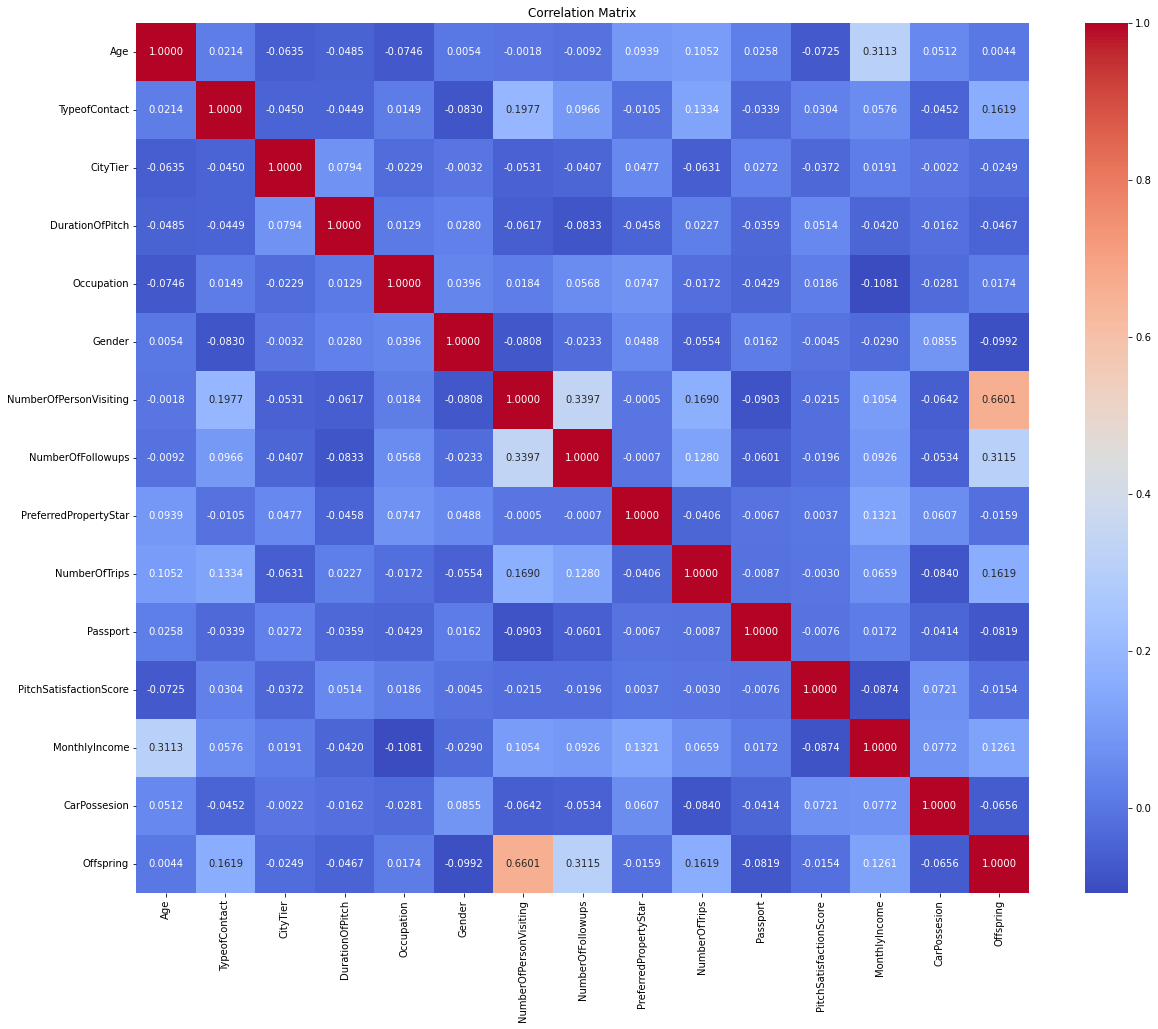

In [170]:
# 相関係数行列を計算
tr_x_cleaned = tr_x_cleaned.dropna()
correlation_matrix = tr_x_cleaned.corr(method='kendall')

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [171]:
test_x

,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,CarPossesion,Offspring,CityTier_1,CityTier_2,CityTier_3,Occupation_0,Occupation_1,Occupation_2,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4,PitchSatisfactionScore_5,Designation_avp,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,Married_未婚,Married_独身,Married_結婚済み,Married_離婚済み
0,0.946687,1.0,-0.227870,0,-1.898215,0.350704,2.184061,0,1.832762,1,-1.333451,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.875244,1.0,-0.370869,1,-1.898215,0.350704,0.447982,1,-0.738022,0,-1.333451,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.381335,1.0,-0.799868,1,-1.898215,0.350704,-1.288097,0,-1.260141,0,-1.333451,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.786209,0.0,-1.085867,0,-1.898215,0.350704,-1.288097,0,-1.261773,1,-1.333451,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.238158,0.0,-1.085867,0,-1.898215,0.350704,-1.288097,0,-1.144883,1,-1.333451,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,0.238158,0.0,-0.084870,1,-1.898215,-0.736810,-0.709404,0,-1.236124,0,-1.333451,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3485,0.541813,0.0,2.918119,0,0.798943,1.438217,-0.130711,0,-0.088375,1,-0.042528,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3486,-1.482554,1.0,0.916126,0,-0.549636,-0.736810,-0.709404,0,-1.129611,0,-1.333451,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3487,-1.381335,1.0,-0.799868,0,-0.549636,-0.736810,-0.709404,0,-1.097893,0,-0.042528,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [172]:
train_x

,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,CarPossesion,Offspring,CityTier_1,CityTier_2,CityTier_3,Occupation_0,Occupation_1,Occupation_2,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4,PitchSatisfactionScore_5,Designation_avp,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,Married_未婚,Married_独身,Married_結婚済み,Married_離婚済み
0,1.134239,1.0,0.095073,0,-1.919689,0.375232,1.042676,1,-1.363191,0,-1.284346,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.742535,0.0,-0.051299,0,-1.919689,0.375232,-0.693566,1,0.654884,1,-1.284346,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.238396,1.0,-0.636790,1,-1.919689,-0.754534,0.463929,0,-1.038304,0,-1.284346,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.183737,1.0,0.534191,1,-1.919689,-0.754534,-1.272314,0,-0.386119,1,-1.284346,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.931473,0.0,0.387818,1,-1.919689,-0.754534,0.463929,0,-1.302476,1,-1.284346,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,0.120411,1.0,1.705172,0,-0.543241,-0.754534,-0.114819,0,-1.296243,1,-1.284346,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3485,0.120411,1.0,-0.783163,0,0.833207,-0.754534,1.042676,0,-1.275938,1,1.286126,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3486,-0.792034,1.0,-0.051299,1,0.833207,-1.884300,1.042676,0,-0.512978,1,0.000890,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3487,1.742535,0.0,0.095073,0,0.833207,2.634763,2.200171,1,2.309272,0,1.286126,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [173]:
# 変数名と列番号の対応を表示
col = pd.DataFrame(train_x.columns.values).T
col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,CarPossesion,Offspring,CityTier_1,CityTier_2,CityTier_3,Occupation_0,Occupation_1,Occupation_2,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4,PitchSatisfactionScore_5,Designation_avp,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,Married_未婚,Married_独身,Married_結婚済み,Married_離婚済み


In [174]:
# num_select = 100
# rfe = RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select=num_select, step=0.5)
# rfe.fit(train_x, train_y.to_numpy().ravel())
# Train_x = pd.DataFrame(rfe.transform(train_x), columns=train_x.columns[rfe.support_])

# rfe_column_list = Train_x.columns.tolist()
# categorical_features = list(set(categorical_features) & set(rfe_column_list))
# Test_x = test_x[rfe_column_list]


Train_x = train_x.copy()
Test_x = test_x.copy()

# for col in ['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'Offspring']:
#     Train_x = Train_x.drop(columns=col)
#     Test_x = Test_x.drop(columns=col)

col = pd.DataFrame(Train_x.columns.values).T
col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,CarPossesion,Offspring,CityTier_1,CityTier_2,CityTier_3,Occupation_0,Occupation_1,Occupation_2,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4,PitchSatisfactionScore_5,Designation_avp,Designation_executive,Designation_manager,Designation_seniormanager,Designation_vp,Married_未婚,Married_独身,Married_結婚済み,Married_離婚済み


In [196]:
def dummy_ex(feature, train_x, test_x, categorical_features):
    # OneHotEncoder の初期化時に sparse_output 引数を使用
    ohe = OneHotEncoder(sparse_output=False, categories='auto')
    new_array = pd.concat([train_x[[feature]], test_x[[feature]]], axis=0)
    ohe.fit(new_array)
    columns = [f'{feature}_{v}' for v in ohe.categories_[0]]
    dummy_vals_train = pd.DataFrame(ohe.transform(train_x[[feature]]), columns=columns)
    dummy_vals_test = pd.DataFrame(ohe.transform(test_x[[feature]]), columns=columns)
    tr = pd.concat([train_x.drop([feature], axis=1), dummy_vals_train.reset_index(drop=True)], axis=1)
    te = pd.concat([test_x.drop([feature], axis=1), dummy_vals_test.reset_index(drop=True)], axis=1)
    categorical_features = categorical_features + columns
    return tr, te, categorical_features

score_list = []
Train_x = tr_x_cleaned.copy()
Test_x = te_x_cleaned.copy()
print(Train_x.shape)
# categorical_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'Designation', 'Married', 'CarPossesion']
dummy_col = ['CityTier', 'Occupation', 'ProductPitched', 'PreferredPropertyStar', 'PitchSatisfactionScore', 'Designation', 'Married']
for cols in [('TypeofContact', 'Married'),('Passport', 'Married'),('PreferredPropertyStar', 'PitchSatisfactionScore'),('Gender', 'Married'),('Occupation', 'PitchSatisfactionScore'),('PitchSatisfactionScore', 'Designation')]:
    categorical_features = []
    Train_x[f'{cols[0]}_{cols[1]}'] = tr_x_cleaned[cols[0]].astype(str) + '_' + tr_x_cleaned[cols[1]].astype(str)
    Test_x[f'{cols[0]}_{cols[1]}'] = te_x_cleaned[cols[0]].astype(str) + '_' + te_x_cleaned[cols[1]].astype(str)
    dummy_col.append(f'{cols[0]}_{cols[1]}')
print(Train_x.shape)

for col in dummy_col:
    Train_x, Test_x, categorical_features = dummy_ex(col, Train_x, Test_x, categorical_features)
print(Train_x.shape)
#LightGBMのハイパーパラメータ設定
params = {
    'objective': 'binary', 
    'metric': 'auc',
    'num_leaves': 23,
    'learning_rate': 0.05, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l1': 0.81,
    'lambda_l2': 90
}
preds = []
splits = 7
auc_sum = []

kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]

    train_set = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    val_set = lgb.Dataset(X_val, y_val, categorical_feature=categorical_features)

    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)

    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    pred = model.predict(Test_x)
    preds.append(pred)

    print(f'Fold {fold + 1}: AUC = {auc:4f}')
    auc_sum.append(auc)

    #特徴量の重要度を出力する
#     importances = model.feature_importance()
#     column_names = Train_x.columns.values
#     temp = []
#     for i in range(len(column_names)):
#         temp.append([importances[i],column_names[i]])
#     temp.sort(reverse=True, key=lambda x:x[0])
#     for i in range(len(temp)):
#         print(temp[i][0]," : ",temp[i][1])

#     score_list.append([cols, np.mean(auc_sum)])
#     print((cols, np.mean(auc_sum)))
# print(score_list)

print(np.mean(auc_sum))

last_pred_1 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_1[i] += preds[j][i]
    last_pred_1[i] /= splits
    


(3489, 18)
(3489, 24)
(3489, 118)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.859666	valid_1's auc: 0.847706
[200]	training's auc: 0.876599	valid_1's auc: 0.849689
[300]	training's auc: 0.887004	valid_1's auc: 0.850138
Early stopping, best iteration is:
[210]	training's auc: 0.877198	valid_1's auc: 0.850588
Fold 1: AUC = 0.850588
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.854778	valid_1's auc: 0.868689
[200]	training's auc: 0.873709	valid_1's auc: 0.869767
Early stopping, best iteration is:
[151]	training's auc: 0.865965	valid_1's auc: 0.871385
Fold 2: AUC = 0.871385
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.859656	valid_1's auc: 0.854364
[200]	training's auc: 0.876394	valid_1's auc: 0.860489
[300]	training's auc: 0.887783	valid_1's auc: 0.859662
Early stopping, best iteration is:
[226]	training's auc: 0.879461	valid_1's auc: 0.861674
Fold 3: AUC = 0.861674
T

In [197]:
#提出用ファイルの作成
submission = pd.DataFrame({'ID':test0['id'], 'ProdTaken':last_pred_1})
# submission.to_csv('YutaK7.csv', index=False, header=None)

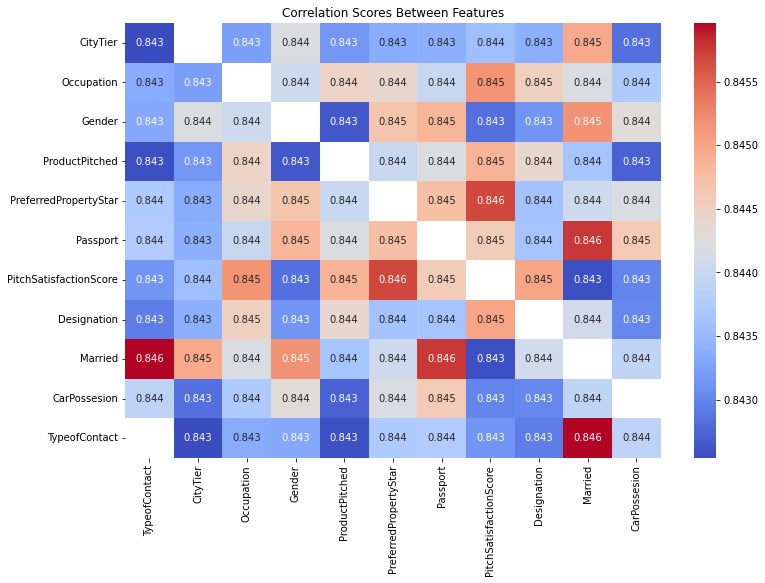

[[('TypeofContact', 'Married'), 0.845960642417554],
 [('Passport', 'Married'), 0.845763689986181],
 [('PreferredPropertyStar', 'PitchSatisfactionScore'), 0.8456891534448111],
 [('Gender', 'Married'), 0.8451709673253109],
 [('Occupation', 'PitchSatisfactionScore'), 0.8451511942457893],
 [('PitchSatisfactionScore', 'Designation'), 0.8450053348886681],
 [('CityTier', 'Married'), 0.8449651680973348],
 [('ProductPitched', 'PitchSatisfactionScore'), 0.8448681119046605],
 [('Gender', 'Passport'), 0.8448485871368449],
 [('PreferredPropertyStar', 'Passport'), 0.8447437984471012],
 [('Gender', 'PreferredPropertyStar'), 0.8446680663330556],
 [('Passport', 'CarPossesion'), 0.844610493184779],
 [('Passport', 'PitchSatisfactionScore'), 0.8445775783462667],
 [('Occupation', 'Designation'), 0.844517173891952],
 [('Occupation', 'ProductPitched'), 0.8444679287145892],
 [('Occupation', 'PreferredPropertyStar'), 0.8444113390372838],
 [('ProductPitched', 'Designation'), 0.8443936846109483],
 [('Gender', 'C

In [192]:
matrix_data = {}
for (a, b), score in score_list:
    matrix_data.setdefault(a, {})[b] = score
    matrix_data.setdefault(b, {})[a] = score

# DataFrame を作成
df_scores = pd.DataFrame(matrix_data)

# ヒートマップをプロット
plt.figure(figsize=(12, 8))
sns.heatmap(df_scores, annot=True, fmt=".3f", cmap='coolwarm', cbar=True)
plt.title('Correlation Scores Between Features')
plt.show()

sorted_data = sorted(score_list, key=lambda x: x[1], reverse=True)
sorted_data

('TypeofContact', 'Married'),('Passport', 'Married'),('PreferredPropertyStar', 'PitchSatisfactionScore'),('Gender', 'Married'),('Occupation', 'PitchSatisfactionScore'),('PitchSatisfactionScore', 'Designation')


# 各モデルの比較

## ①lightGBM

In [178]:
#LightGBMのハイパーパラメータ設定
params = {
    'objective': 'binary', 
    'metric': 'auc',
    'num_leaves': 23,
    'learning_rate': 0.05, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l1': 0.81,
    'lambda_l2': 90
}
# auc_sum = []
preds = []
splits = 7
score_list = []
# for i in range(1, 62):
auc_sum = []
#     num_select = i * 10
    
#     rfe = RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select=num_select, step=0.5)
#     rfe.fit(train_x, train_y.to_numpy().ravel())
#     Train_x = pd.DataFrame(rfe.transform(train_x), columns=train_x.columns[rfe.support_])
#     rfe_column_list = Train_x.columns.tolist()
#     categorical_features_0 = list(set(categorical_features) & set(rfe_column_list))
#     Test_x = test_x[rfe_column_list]

kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]

    train_set = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    val_set = lgb.Dataset(X_val, y_val, categorical_feature=categorical_features)

    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)

    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    pred = model.predict(Test_x)
    preds.append(pred)

    print(f'Fold {fold + 1}: AUC = {auc:4f}')
    auc_sum.append(auc)

#特徴量の重要度を出力する
importances = model.feature_importance()
column_names = Train_x.columns.values
temp = []
for i in range(len(column_names)):
    temp.append([importances[i],column_names[i]])
temp.sort(reverse=True, key=lambda x:x[0])
for i in range(len(temp)):
    print(temp[i][0]," : ",temp[i][1])

#     score_list.append((num_select, np.mean(auc_sum)))
#     print((num_select, np.mean(auc_sum)))
# print(score_list)

print(np.mean(auc_sum))

# last_pred_1 = 3489 * [0.0]
# for i in range(3489):
#     for j in range(splits):
#         last_pred_1[i] += preds[j][i]
#     last_pred_1[i] /= splits

# ensemble_preds = []
# ensemble_preds.append(last_pred_1)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.851313	valid_1's auc: 0.846059
[200]	training's auc: 0.869713	valid_1's auc: 0.850887
[300]	training's auc: 0.881108	valid_1's auc: 0.850588
Early stopping, best iteration is:
[247]	training's auc: 0.87607	valid_1's auc: 0.852309
Fold 1: AUC = 0.852309
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.84776	valid_1's auc: 0.864897
[200]	training's auc: 0.867464	valid_1's auc: 0.868015
Early stopping, best iteration is:
[169]	training's auc: 0.863149	valid_1's auc: 0.868925
Fold 2: AUC = 0.868925
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.850256	valid_1's auc: 0.84542
[200]	training's auc: 0.870421	valid_1's auc: 0.854418
Early stopping, best iteration is:
[151]	training's auc: 0.863246	valid_1's auc: 0.855747
Fold 3: AUC = 0.855747
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.853373	

In [89]:
0.8423398524930346

0.8443110090534068

0.844521901118244

0.8481805819680117 70

0.844521901118244

In [90]:
#提出用ファイルの作成
submission = pd.DataFrame({'ID':test0['id'], 'ProdTaken':last_pred_1})
# submission.to_csv('YutaK6.csv', index=False, header=None)

In [164]:
sorted_data = sorted(score_list, key=lambda x: x[1])
sorted_data

[(10, 0.8141408910091144),
 (20, 0.8335852668082075),
 (30, 0.8399608354653353),
 (610, 0.8417081222195902),
 (550, 0.8422777136680398),
 (590, 0.8423194187601899),
 (540, 0.8426210773322287),
 (570, 0.8426371753200568),
 (560, 0.8426909800430354),
 (530, 0.8427895774535583),
 (510, 0.8428342980081952),
 (580, 0.842959809153002),
 (450, 0.8430854166843892),
 (40, 0.8431521518601645),
 (600, 0.8433018448230547),
 (500, 0.8433060606812822),
 (390, 0.8436445352453762),
 (380, 0.8437078843737412),
 (470, 0.8437342376631352),
 (490, 0.8438058692148411),
 (480, 0.8439346224070909),
 (460, 0.843986869624657),
 (440, 0.8440874422788579),
 (520, 0.8441915209268019),
 (400, 0.8442906020734934),
 (370, 0.8445292953743281),
 (430, 0.844540898306172),
 (420, 0.8448779531169129),
 (410, 0.8448803342734325),
 (360, 0.844892732695458),
 (300, 0.8449125739200639),
 (330, 0.8451939439159979),
 (340, 0.8452245342176814),
 (350, 0.8456711217653238),
 (290, 0.8461984717771963),
 (280, 0.846325401445465),
 

## ②LogisticRegression(アンサンブルで0倍が最適のため不採用)

In [26]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    model = LogisticRegression(penalty = 'none',
                               dual = False,
                               tol = 0.001,
                               C = 1.0,
                               fit_intercept = True,
                               intercept_scaling = 1,
                               class_weight = None,
                               random_state = None,
                               solver = 'saga',
                               max_iter = 100,
                               multi_class = 'auto',
                               verbose = 0,
                               warm_start = False,
                               n_jobs = None,
                               l1_ratio = None
                              )
    #訓練データをモデルに適合させる
    model.fit(X_tr, y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = model.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = model.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_2 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_2[i] += preds[j][i]
    last_pred_2[i] /= splits

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'elasticnet', 'l1', 'l2'} or None. Got 'none' instead.

## ③SGDClassifier(アンサンブルで0倍が最適のため不採用)

In [ ]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits=splits,shuffle=True,random_state=71)

for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val,y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    #ロジスティック回帰のインスタンスを生成
    lr = SGDClassifier(penalty='elasticnet',
                       alpha = 0.003,
                       l1_ratio = 0.3,
                       tol=0.0001,
                       fit_intercept=True,
                       class_weight='balanced',
                       random_state=None,
                       max_iter=1000,
                       verbose=0,
                       warm_start=False,
                       n_jobs=None,
                       loss ='log_loss'
                       )
    #訓練データをモデルに適合させる
    lr.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = lr.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = lr.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_3 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_3[i] += preds[j][i]
    last_pred_3[i] /= splits

## ④SVM(処理に時間がかかりすぎたため不採用)

In [ ]:
'''
from sklearn.pipeline import Pipeline

auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = svm.SVC(kernel = 'linear', probability = True)
    
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict(X_val, prediction_type='Probability')
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict(Test_x, prediction_type='Probability')
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_4 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_4[i] += preds[j][i]
    last_pred_4[i] /= splits


curve = roc_curve(test_y, last_pred_4)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_4)
print(auc_test)
'''

pass

## ⑤決定木(他に比べて明らかにスコアが低いので不採用)

In [ ]:
from sklearn import tree

auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = tree.DecisionTreeClassifier(criterion = 'gini',
                                      splitter = 'best',
                                      max_depth = 4, 
                                      min_samples_split = 3,
                                      min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0.0,
                                      max_features = 4,
                                      random_state = None,
                                      max_leaf_nodes = 8,
                                      min_impurity_decrease = 1e-07,
                                      class_weight = 'balanced'
                                     )
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_5 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_5[i] += preds[j][i]
    last_pred_5[i] /= splits

## ⑥ランダムフォレスト

In [ ]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = RandomForestClassifier(random_state = 53)
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_6 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_6[i] += preds[j][i]
    last_pred_6[i] /= splits

# ensemble_preds.append(last_pred_6)

# ⑦アダブースト

In [ ]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = AdaBoostClassifier(random_state = 53)
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_7 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_7[i] += preds[j][i]
    last_pred_7[i] /= splits

# ensemble_preds.append(last_pred_7)

## ⑧catboost

In [ ]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 74)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    train_pool = Pool(X_tr, label = y_tr)
    test_pool  = Pool(X_val,label = y_val)
    
    params = {
        'depth' : 6,
        'learning_rate' : 0.16,
        'early_stopping_rounds' : 10,
        'iterations' : 200,
        'custom_loss' : ['Accuracy'],
        'random_seed' : 42,   
    }

    clf = CatBoostClassifier(**params)
    #訓練データをモデルに適合させる
    clf.fit(train_pool, eval_set = test_pool)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict(X_val, prediction_type='Probability')
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict(Test_x, prediction_type='Probability')
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_8 = 3489 * [0.0]
for i in range(3489):
    for j in range(splits):
        last_pred_8[i] += preds[j][i]
    last_pred_8[i] /= splits

ensemble_preds.append(last_pred_8)

# 最終スコアの算出

## アンサンブル

In [ ]:
from itertools import product

def find_permutations(n):
    perm_list = []
    current_perm = [0] * n
    
    while True:
        if sum(current_perm) == 10:
            perm_list.append(tuple(current_perm))
    
        i = n-1
        while i >= 0 and current_perm[i] == 10:
            current_perm[i] = 0
            i -= 1
            
        if i < 0:
            break
        
        current_perm[i] += 1
    
    return perm_list

n = 4
permutations = find_permutations(n)
last_pred = len(test_y) * [0.0]
l = []
for i in range(n):
    l.append(0.0)
best_score = 0
for perm in permutations:
    for i in range(len(test_y)):
        last_pred_list = len(test_y) * l
        last_pred_list[i] = [last_pred_1[i], last_pred_6[i], last_pred_7[i], last_pred_8[i]]
        last_pred[i] = np.dot(last_pred_list[i], perm) / 10
    auc_test = roc_auc_score(test_y, last_pred)
    if auc_test > best_score:
        best_score = auc_test
        best_perm = perm
    print(perm, auc_test)
print('best param is ', best_perm, ', best score is ', best_score)

In [ ]:
def max_score(preds,dif,test_y,over_value_sum = [0.0], depth = [0],max = [0.0], ensemble_pred = [0.0],max_ratio = [0.0], now_ratio = [0.0]):
    
    if len(preds) == depth[0]+1: #最深部での処理
        temp_ensemble_pred = len(preds[0])*[0.0]
        
        for i in range(len(preds[0])):
            temp_ensemble_pred[i] = ensemble_pred[i]
            
        value = 1.0 - over_value_sum[0]
        now_ratio[depth[0]] = value
        
        for i in range(len(preds[0])):
            ensemble_pred[i] += preds[depth[0]][i]*value
        ensemble_auc = roc_auc_score(test_y,ensemble_pred)
        
        for i in range(len(preds[0])):
            ensemble_pred[i] = temp_ensemble_pred[i]
            
        if ensemble_auc > max[0]:
            for i in range(len(now_ratio)):
                max_ratio[i] = now_ratio[i]
            max[0] = ensemble_auc
        
        
    elif depth[0] == 0:              #最浅部での処理
        ensemble_pred = len(preds[0])*[0.0] #最深部でAUCを計算するためのリスト
        max_ratio  = len(preds)*[0.0]       #AUCの最大値を更新した際に、それを与えたアンサンブル割合を格納するリスト
        now_ratio  = len(preds)*[0.0]       #現在のアンサンブル割合を格納するリスト
        while over_value_sum[0]<=1.0+dif:
                
            max_score(preds=preds,dif=dif,test_y=test_y,over_value_sum= over_value_sum,depth = [1], max = max, ensemble_pred = ensemble_pred, max_ratio = max_ratio, now_ratio = now_ratio)
            
            for i in range(len(preds[0])):
                ensemble_pred[i] += preds[depth[0]][i]*dif
                
            now_ratio[depth[0]] += dif
            over_value_sum[0] += dif
            
        return [max[0],max_ratio]
    else:  #その他の深さでの処理
        now_ratio[depth[0]] = 0.0
        temp_ratio = now_ratio
        temp_over_value_sum = over_value_sum[0]
        
        temp_ensemble_pred = len(preds[0])*[0.0]
        for i in range(len(preds[0])):
            temp_ensemble_pred[i] = ensemble_pred[i]
            
        while over_value_sum[0]<=1.0:
                
            max_score(preds=preds,dif=dif,test_y=test_y,over_value_sum = over_value_sum, depth = [depth[0]+1],max = max, ensemble_pred = ensemble_pred, max_ratio = max_ratio, now_ratio = now_ratio)
            
            for i in range(len(preds[0])):
                ensemble_pred[i] += preds[depth[0]][i]*dif
                
            now_ratio[depth[0]] += dif
            over_value_sum[0] += dif
        now_ratio = temp_ratio
        over_value_sum[0] = temp_over_value_sum
        
        for i in range(len(preds[0])):
            ensemble_pred[i] = temp_ensemble_pred[i]
            
        now_ratio[depth[0]] = 0.0
        
#アンサンブル処理
dif = 0.05
result = max_score(preds = ensemble_preds, dif = dif, test_y = test_y)
print(result)